In [30]:
import torch
import numpy as np
from datatypes import torchcomplex, show
from gate_implementation_anysize import apply_gate, apply_sparse_gate, device
import time

In [31]:
def test_correctness():
    psi0 = torch.arange(8, device=device) + 1
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    XZ = np.kron(X, Z)
    XZ = torchcomplex(XZ).to(device)
    psi1 = apply_gate([1, 2], XZ, psi0)
    np.testing.assert_allclose(
        psi1.cpu(), torch.tensor([3, -4, 1, -2, 7, -8, 5, -6]).cpu(), atol=0.00001
    )
    print("Correctness test passed for dense")

    XZ_sparse=(
        [(0,2),(1,3),(2,0),(3,1)],
        torchcomplex(np.array([1.0,-1.0,1.0,-1.0]))
    )
    psi2 = apply_sparse_gate([1, 2], XZ_sparse, psi0)
    np.testing.assert_allclose(
        psi2.cpu(), torch.tensor([3, -4, 1, -2, 7, -8, 5, -6]).cpu(), atol=0.00001
    )
    print("Correctness test passed for sparse")

In [32]:
class PerfTest:
    @staticmethod
    def time(n, positions, sparse=False):

        if device.type == "cuda":
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

        if isinstance(positions, int):
            positions = list(range(positions))

        k = len(positions)
        if sparse:
            matrix = PerfTest.get_k_qubit_sparse_Xk(k)
        else:
            matrix = PerfTest.get_k_qubit_dense_Hadamard(k)

        psi0 = PerfTest.get_state(n)
        if device.type == "cuda":
            start.record()
            PerfTest.apply_gate_to_qubits(positions, matrix, psi0, sparse=sparse)
            end.record()
            """https://discuss.pytorch.org/t/how-to-measure-time-in-pytorch/26964/10"""
            torch.cuda.synchronize()

        else:
            t0 = time.time()
            PerfTest.apply_gate_to_qubits(positions, matrix, psi0, sparse=sparse)
            t1 = time.time()

        if device.type == "cuda":
            s = start.elapsed_time(end) / 1000
        else:
            s = t1 - t0
            
        if sparse:
            print(f"{s:.4f} s for sparse {k} qubit X^k gate on {n} qubit state")
        else:
            print(f"{s:.4f} s for dense {k} qubit Hadamard gate on {n} qubit state")

        return s

    @staticmethod
    def apply_gate_to_qubits(positions, matrix, psi0, sparse=False):
        if sparse:
            return apply_sparse_gate(positions, matrix, psi0)
        else:
            return apply_gate(positions, matrix, psi0)
        
    @staticmethod
    def get_state(n):
        return torch.arange(2**n, device=device)
    
    @staticmethod
    def get_k_qubit_dense_Hadamard(k):
        X = torchcomplex(np.array([[1, 1], [1, -1]]) / np.sqrt(2)).to(device)
        X_ = torchcomplex(np.array([[1]])).to(device)
        for _ in range(k):
            X_ = torch.kron(X_, X)
        return X_
    
    @staticmethod
    def get_k_qubit_sparse_Xk(k):
        K = 2**k
        I = torch.arange(K, device=device)
        J = K - I
        V = torch.ones(K, device=device)
        matrix_indices = torch.stack([I, J], dim=1)
        return (matrix_indices, V)

In [33]:
test_correctness()

Correctness test passed for dense
Correctness test passed for sparse


In [36]:
densetimes=dict()
sparsetimes=dict()

for k in range(1,9):
    densetimes[k]=PerfTest.time(20, k)

for k in range(1,15):
    sparsetimes[k]=PerfTest.time(20, k, sparse=True)

0.0017 s for dense 1 qubit Hadamard gate on 20 qubit state
0.0041 s for dense 2 qubit Hadamard gate on 20 qubit state
0.0102 s for dense 3 qubit Hadamard gate on 20 qubit state
0.0287 s for dense 4 qubit Hadamard gate on 20 qubit state
0.0781 s for dense 5 qubit Hadamard gate on 20 qubit state
0.2382 s for dense 6 qubit Hadamard gate on 20 qubit state
0.8259 s for dense 7 qubit Hadamard gate on 20 qubit state
3.0839 s for dense 8 qubit Hadamard gate on 20 qubit state
11.6322 s for dense 9 qubit Hadamard gate on 20 qubit state
45.3797 s for dense 10 qubit Hadamard gate on 20 qubit state
0.0008 s for sparse 1 qubit X^k gate on 20 qubit state
0.0010 s for sparse 2 qubit X^k gate on 20 qubit state
0.0015 s for sparse 3 qubit X^k gate on 20 qubit state
0.0027 s for sparse 4 qubit X^k gate on 20 qubit state
0.0055 s for sparse 5 qubit X^k gate on 20 qubit state
0.0118 s for sparse 6 qubit X^k gate on 20 qubit state
0.0260 s for sparse 7 qubit X^k gate on 20 qubit state
0.0566 s for sparse 8 

Text(0.5, 1.0, 'Time to apply k-qubit gate to 20-qubit state')

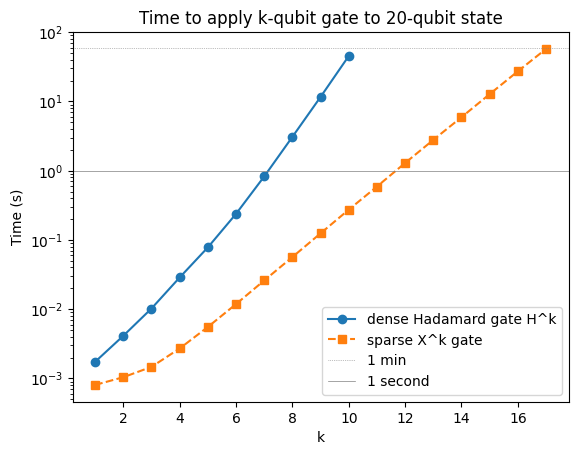

In [50]:
import matplotlib.pyplot as plt

plt.plot(densetimes.keys(), densetimes.values(),'-o', label="dense Hadamard gate H^k")
plt.plot(sparsetimes.keys(), sparsetimes.values(),'--s', label="sparse X^k gate")

plt.xlabel("k")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.axhline(60,lw=.5,ls=':',color='gray',label="1 min")
plt.axhline(1,lw=.5,color='gray',label="1 second")
plt.legend()

plt.title("Time to apply k-qubit gate to 20-qubit state")

In [51]:
#plt.savefig("example_outputs/many_qubit_gate_perftest.pdf")

<Figure size 640x480 with 0 Axes>